In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.datasets import DatasetFolder

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

In [3]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

In [4]:
trainset = ImageFolder("trafic_32/", transform=transform)

train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size

# Podział trainset na zbiory treningowy i testowy
train_dataset, test_dataset = random_split(trainset, [train_size, test_size])

# Utworzenie DataLoader dla każdego zbioru danych
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=16)


classes = trainset.classes



In [5]:
def get_train_images(num):
    inverse_transform = transforms.Compose([
    transforms.Normalize(mean=(-0.5 / 0.5), std=(1 / 0.5)),
    transforms.Normalize(mean=(-0.5, -0.5, -0.5), std=(1, 1, 1))
])
    return torch.stack([inverse_transform(test_dataset[i][0]) for i in range(10, 10 + num)], dim=0)

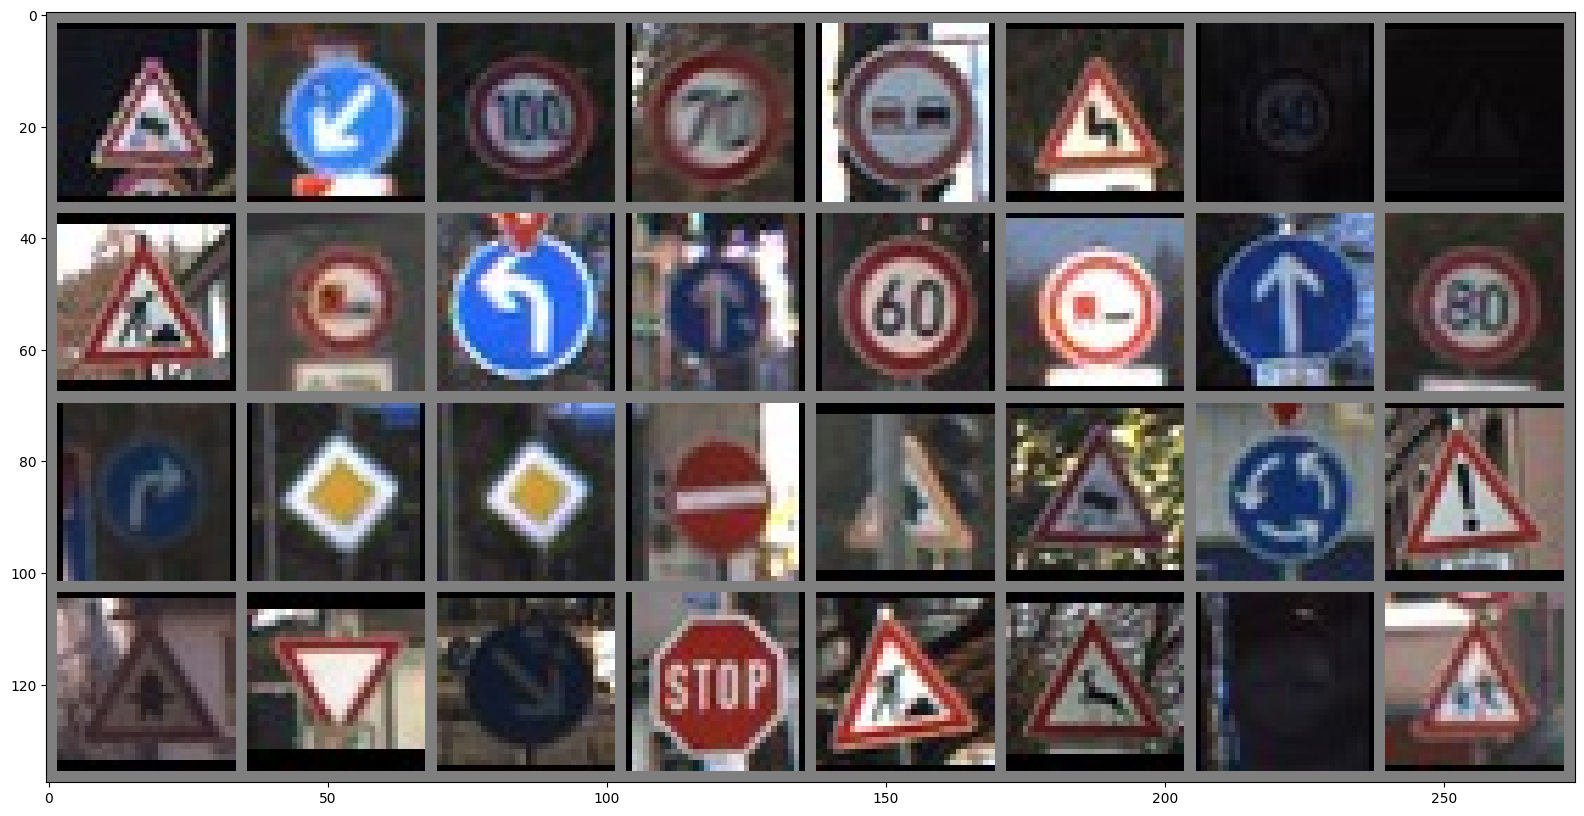

00023 00039 00007 00004 00009 00021 00003 00018 00025 00010 00034 00035 00003 00010 00035 00005 00033 00012 00012 00017 00011 00023 00040 00018 00011 00013 00038 00014 00025 00031 00009 00028


In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
images, labels = next(iter(train_loader))
images[0:1].size()

torch.Size([1, 3, 32, 32])

In [25]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.norm1(self.fc_1(x)))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [26]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.norm1(self.fc_1(x)))
        h     = self.LeakyReLU(self.norm2(self.fc_2(h)))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat
        

In [29]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        # Change to proper sampling
        # z = mean
        # z = tprch.normal(mean,var)
        z = torch.randn_like(mean)*var+mean
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [30]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=3*32*32).to(device)
input_imgs = get_train_images(8)

In [31]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [32]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [33]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.norm1(self.fc_1(x)))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var
    

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.norm1(self.fc_1(x)))
        h     = self.LeakyReLU(self.norm2(self.fc_2(h)))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat
    
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        # Change to proper sampling
        # z = mean
        # z = tprch.normal(mean,var)
        z = torch.randn_like(mean)*var+mean
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var
        

In [34]:


num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 42231.6477964131, test L1 = 0.5722915825805044
Epoch 1 loss 39964.06396733244, test L1 = 0.566051977436717
Epoch 2 loss 39540.53932829224, test L1 = 0.5624916160978922
Epoch 3 loss 39317.672930205146, test L1 = 0.5613167959500135
Epoch 4 loss 39154.86866528494, test L1 = 0.5596746154190079
Epoch 5 loss 39061.99994823522, test L1 = 0.5580624024557873
Epoch 6 loss 38954.005041093274, test L1 = 0.5568541414369412
Epoch 7 loss 38896.14738826771, test L1 = 0.5561603047256547
Epoch 8 loss 38824.958731523955, test L1 = 0.5553330700329648
Epoch 9 loss 38766.09368429855, test L1 = 0.5542372858863536
Epoch 10 loss 38715.572774811255, test L1 = 0.5537563951277151
Epoch 11 loss 38645.547110927946, test L1 = 0.554845882140524
Epoch 12 loss 38607.199128161636, test L1 = 0.5522442779889921
Epoch 13 loss 38553.982298435905, test L1 = 0.5533769462651353
Epoch 14 loss 38518.08093025293, test L1 = 0.5522228255262219
Epoch 15 loss 38497.19171235904, test L1 = 0.5513694887238789
Epoch 16 loss 

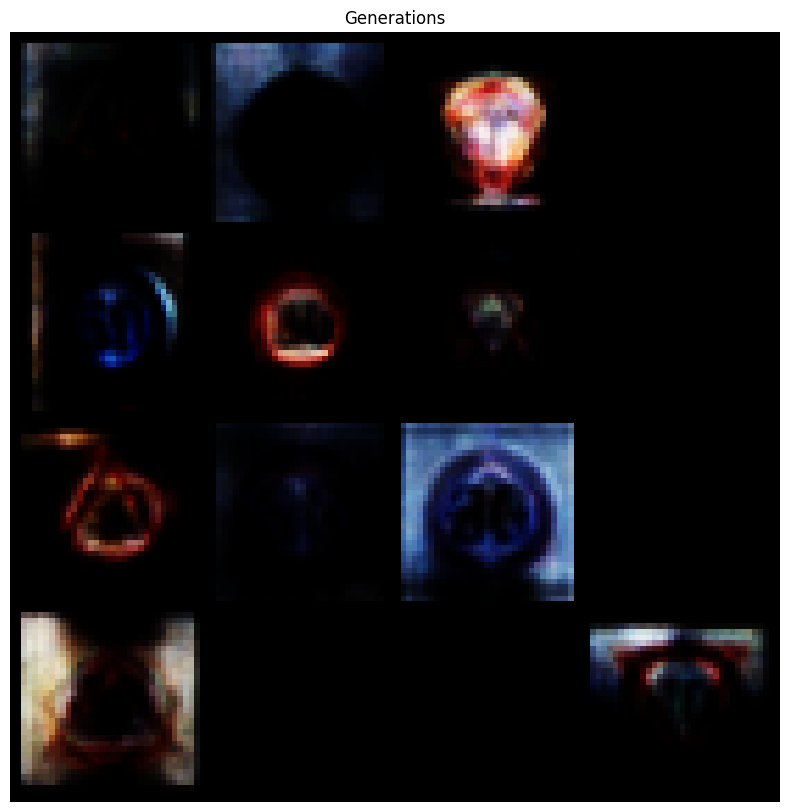

In [35]:
generate_images(vae, 16 , device)

In [17]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


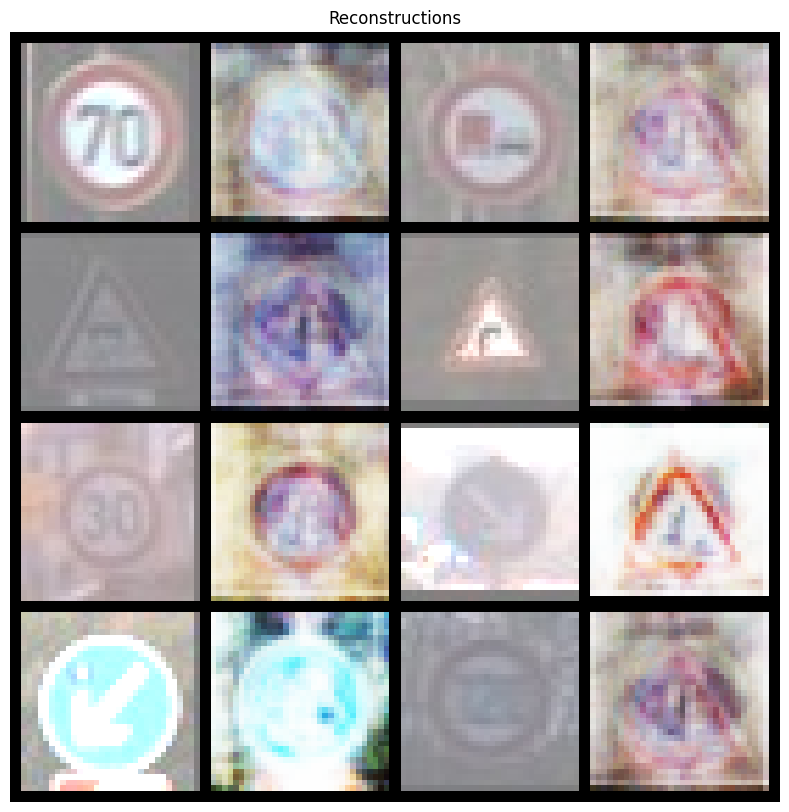

In [18]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [19]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [21]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=3*32*32).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=3*32*32).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [22]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.0109, discriminator real acc: 0.973


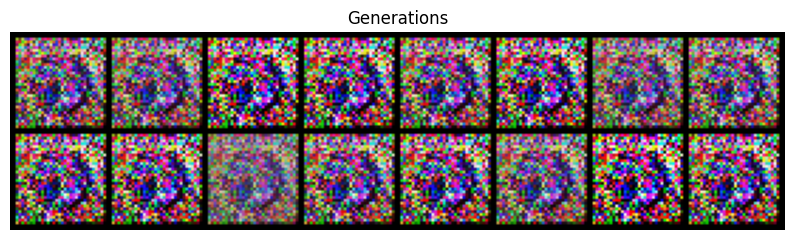

Epoch: 1, discrimiantor fake error: 0.00371, discriminator real acc: 0.992
Epoch: 2, discrimiantor fake error: 0.00403, discriminator real acc: 0.993
Epoch: 3, discrimiantor fake error: 0.00457, discriminator real acc: 0.994
Epoch: 4, discrimiantor fake error: 0.00885, discriminator real acc: 0.994
Epoch: 5, discrimiantor fake error: 0.00798, discriminator real acc: 0.994
Epoch: 6, discrimiantor fake error: 0.00606, discriminator real acc: 0.994
Epoch: 7, discrimiantor fake error: 0.0059, discriminator real acc: 0.995
Epoch: 8, discrimiantor fake error: 0.00578, discriminator real acc: 0.995
Epoch: 9, discrimiantor fake error: 0.00653, discriminator real acc: 0.994
Epoch: 10, discrimiantor fake error: 0.00579, discriminator real acc: 0.994


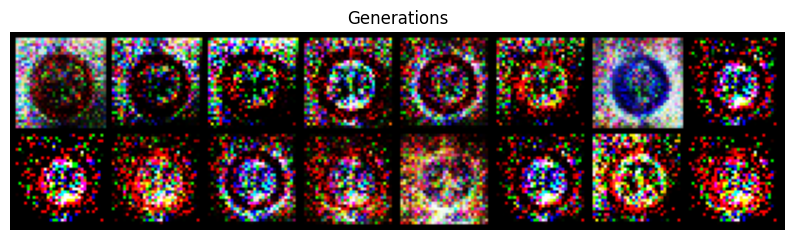

Epoch: 11, discrimiantor fake error: 0.00583, discriminator real acc: 0.995
Epoch: 12, discrimiantor fake error: 0.00616, discriminator real acc: 0.994
Epoch: 13, discrimiantor fake error: 0.00603, discriminator real acc: 0.994
Epoch: 14, discrimiantor fake error: 0.00544, discriminator real acc: 0.995
Epoch: 15, discrimiantor fake error: 0.00546, discriminator real acc: 0.995
Epoch: 16, discrimiantor fake error: 0.00537, discriminator real acc: 0.995
Epoch: 17, discrimiantor fake error: 0.00447, discriminator real acc: 0.995
Epoch: 18, discrimiantor fake error: 0.00553, discriminator real acc: 0.995
Epoch: 19, discrimiantor fake error: 0.00492, discriminator real acc: 0.995
Epoch: 20, discrimiantor fake error: 0.00478, discriminator real acc: 0.996


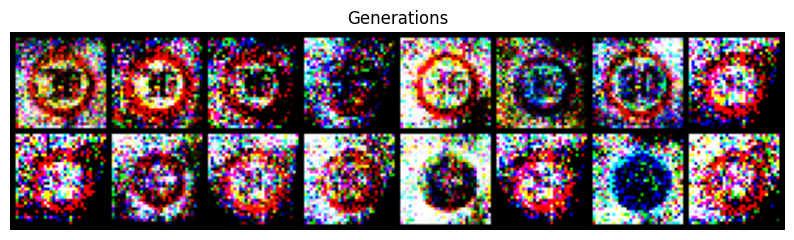

Epoch: 21, discrimiantor fake error: 0.00486, discriminator real acc: 0.996
Epoch: 22, discrimiantor fake error: 0.0048, discriminator real acc: 0.995
Epoch: 23, discrimiantor fake error: 0.0049, discriminator real acc: 0.995
Epoch: 24, discrimiantor fake error: 0.00458, discriminator real acc: 0.996
Epoch: 25, discrimiantor fake error: 0.0046, discriminator real acc: 0.996
Epoch: 26, discrimiantor fake error: 0.00423, discriminator real acc: 0.996
Epoch: 27, discrimiantor fake error: 0.00381, discriminator real acc: 0.996
Epoch: 28, discrimiantor fake error: 0.00359, discriminator real acc: 0.996
Epoch: 29, discrimiantor fake error: 0.0031, discriminator real acc: 0.997
Epoch: 30, discrimiantor fake error: 0.00288, discriminator real acc: 0.997


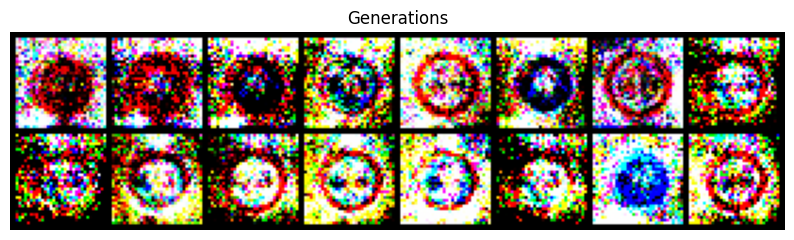

Epoch: 31, discrimiantor fake error: 0.00323, discriminator real acc: 0.997
Epoch: 32, discrimiantor fake error: 0.00337, discriminator real acc: 0.997
Epoch: 33, discrimiantor fake error: 0.00376, discriminator real acc: 0.997
Epoch: 34, discrimiantor fake error: 0.00337, discriminator real acc: 0.997
Epoch: 35, discrimiantor fake error: 0.00406, discriminator real acc: 0.996
Epoch: 36, discrimiantor fake error: 0.00356, discriminator real acc: 0.997
Epoch: 37, discrimiantor fake error: 0.00287, discriminator real acc: 0.997
Epoch: 38, discrimiantor fake error: 0.00349, discriminator real acc: 0.997
Epoch: 39, discrimiantor fake error: 0.00301, discriminator real acc: 0.997
Epoch: 40, discrimiantor fake error: 0.00296, discriminator real acc: 0.997


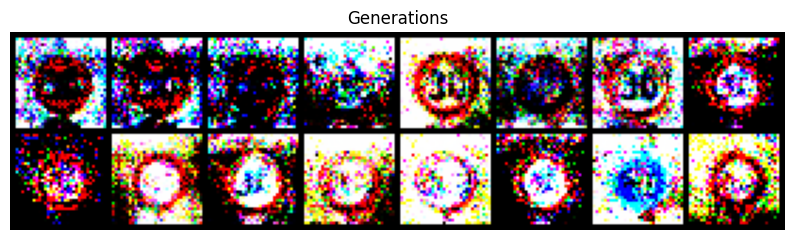

Epoch: 41, discrimiantor fake error: 0.00274, discriminator real acc: 0.997
Epoch: 42, discrimiantor fake error: 0.00277, discriminator real acc: 0.997
Epoch: 43, discrimiantor fake error: 0.00299, discriminator real acc: 0.997
Epoch: 44, discrimiantor fake error: 0.00272, discriminator real acc: 0.997
Epoch: 45, discrimiantor fake error: 0.00261, discriminator real acc: 0.997
Epoch: 46, discrimiantor fake error: 0.00253, discriminator real acc: 0.997
Epoch: 47, discrimiantor fake error: 0.0025, discriminator real acc: 0.998
Epoch: 48, discrimiantor fake error: 0.00207, discriminator real acc: 0.998
Epoch: 49, discrimiantor fake error: 0.00233, discriminator real acc: 0.998
Epoch: 50, discrimiantor fake error: 0.00217, discriminator real acc: 0.998


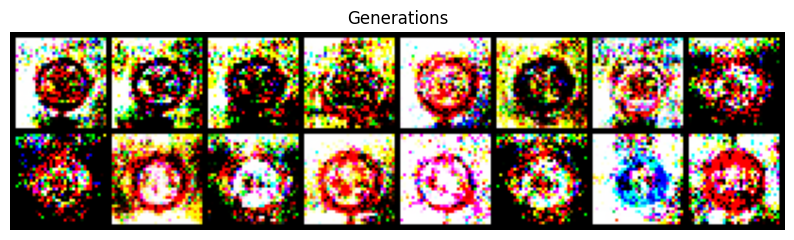

Epoch: 51, discrimiantor fake error: 0.00196, discriminator real acc: 0.998
Epoch: 52, discrimiantor fake error: 0.00213, discriminator real acc: 0.998
Epoch: 53, discrimiantor fake error: 0.00197, discriminator real acc: 0.998
Epoch: 54, discrimiantor fake error: 0.00206, discriminator real acc: 0.998
Epoch: 55, discrimiantor fake error: 0.00194, discriminator real acc: 0.998
Epoch: 56, discrimiantor fake error: 0.00187, discriminator real acc: 0.998
Epoch: 57, discrimiantor fake error: 0.00166, discriminator real acc: 0.998
Epoch: 58, discrimiantor fake error: 0.00172, discriminator real acc: 0.998
Epoch: 59, discrimiantor fake error: 0.00167, discriminator real acc: 0.998
Epoch: 60, discrimiantor fake error: 0.00161, discriminator real acc: 0.998


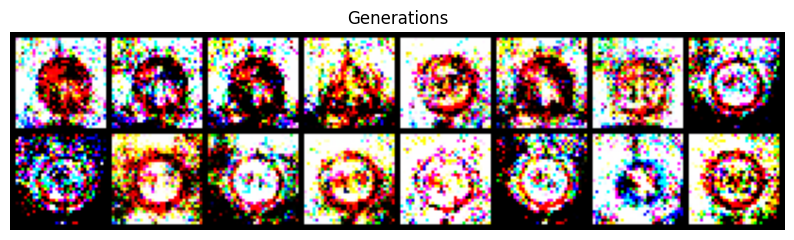

Epoch: 61, discrimiantor fake error: 0.00164, discriminator real acc: 0.998
Epoch: 62, discrimiantor fake error: 0.00189, discriminator real acc: 0.998
Epoch: 63, discrimiantor fake error: 0.00194, discriminator real acc: 0.998
Epoch: 64, discrimiantor fake error: 0.00179, discriminator real acc: 0.998
Epoch: 65, discrimiantor fake error: 0.00169, discriminator real acc: 0.998
Epoch: 66, discrimiantor fake error: 0.00183, discriminator real acc: 0.998
Epoch: 67, discrimiantor fake error: 0.00174, discriminator real acc: 0.998
Epoch: 68, discrimiantor fake error: 0.00166, discriminator real acc: 0.998
Epoch: 69, discrimiantor fake error: 0.00178, discriminator real acc: 0.998
Epoch: 70, discrimiantor fake error: 0.00162, discriminator real acc: 0.998


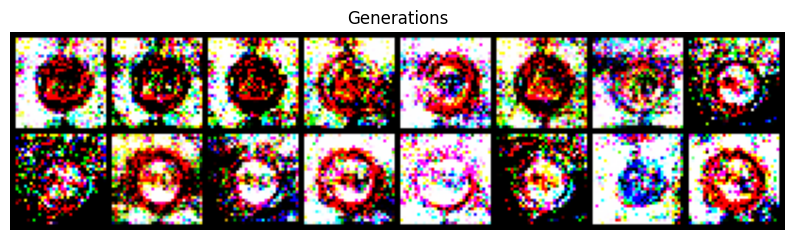

Epoch: 71, discrimiantor fake error: 0.00144, discriminator real acc: 0.998
Epoch: 72, discrimiantor fake error: 0.00156, discriminator real acc: 0.998
Epoch: 73, discrimiantor fake error: 0.00155, discriminator real acc: 0.998
Epoch: 74, discrimiantor fake error: 0.00139, discriminator real acc: 0.999
Epoch: 75, discrimiantor fake error: 0.00139, discriminator real acc: 0.999
Epoch: 76, discrimiantor fake error: 0.00139, discriminator real acc: 0.999
Epoch: 77, discrimiantor fake error: 0.00134, discriminator real acc: 0.999
Epoch: 78, discrimiantor fake error: 0.00126, discriminator real acc: 0.999
Epoch: 79, discrimiantor fake error: 0.00126, discriminator real acc: 0.999
Epoch: 80, discrimiantor fake error: 0.0012, discriminator real acc: 0.999


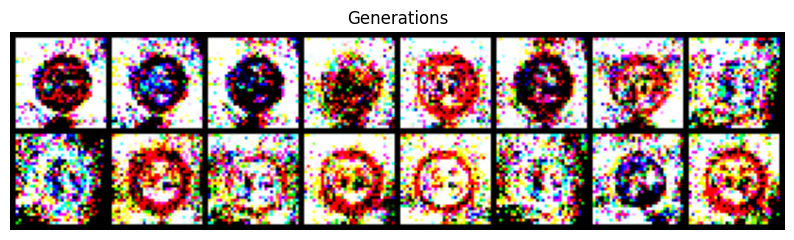

Epoch: 81, discrimiantor fake error: 0.00124, discriminator real acc: 0.999
Epoch: 82, discrimiantor fake error: 0.00124, discriminator real acc: 0.999
Epoch: 83, discrimiantor fake error: 0.00124, discriminator real acc: 0.999
Epoch: 84, discrimiantor fake error: 0.00115, discriminator real acc: 0.999
Epoch: 85, discrimiantor fake error: 0.00123, discriminator real acc: 0.999
Epoch: 86, discrimiantor fake error: 0.00126, discriminator real acc: 0.999
Epoch: 87, discrimiantor fake error: 0.00124, discriminator real acc: 0.999
Epoch: 88, discrimiantor fake error: 0.00121, discriminator real acc: 0.999
Epoch: 89, discrimiantor fake error: 0.000998, discriminator real acc: 0.999
Epoch: 90, discrimiantor fake error: 0.001, discriminator real acc: 0.999


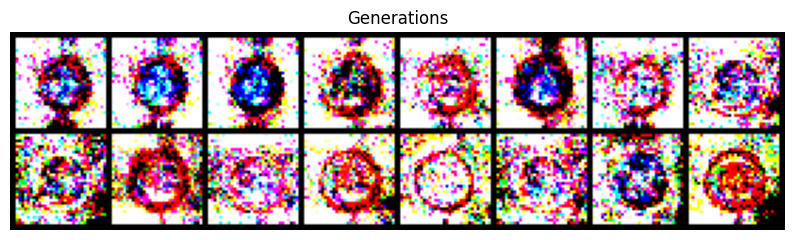

Epoch: 91, discrimiantor fake error: 0.000873, discriminator real acc: 0.999
Epoch: 92, discrimiantor fake error: 0.000913, discriminator real acc: 0.999
Epoch: 93, discrimiantor fake error: 0.000952, discriminator real acc: 0.999
Epoch: 94, discrimiantor fake error: 0.000984, discriminator real acc: 0.999
Epoch: 95, discrimiantor fake error: 0.00106, discriminator real acc: 0.999
Epoch: 96, discrimiantor fake error: 0.00115, discriminator real acc: 0.999
Epoch: 97, discrimiantor fake error: 0.0012, discriminator real acc: 0.999
Epoch: 98, discrimiantor fake error: 0.00113, discriminator real acc: 0.999
Epoch: 99, discrimiantor fake error: 0.00109, discriminator real acc: 0.999


In [23]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [24]:
# torch.save(generated_imgs.cpu().detach(),"poniedzialek_nazwisko1_nazwisko2.pt")

NameError: name 'generated_imgs' is not defined